# Notebook IV: Face Reconstruction with Vec2Instance

Vec2Instance can be used to parametrize other objects going beyond building instances. Such example of parametrization of human faces are demonstrated in this notebook. In this notebook, we attempt to parametrize entire human face while reconstructing the input RGB image of a face with Vec2Instance architecture.

__Content of this notebook:__

    1) Reading and Exploring Data
    2) Importing Trained Models in Notebook I and II and Prediction
    3) Combining Results from Centroids Estimation and Instance Segmenting CNNs
    4) t-SNE Visualization of Face Parameter Space
    
__Dataset citation (http://vis-www.cs.umass.edu/lfw/part_labels/)__: *Kae, A., Sohn, K., Lee, H., Learned-Miller, E.: Augmenting CRFs with Boltzmann Machine Shape priors for image labeling. In: IEEE Conference on Computer Vision and Pattern Recognition (CVPR). (2013)*

<hr>
<hr>
<hr>

In [3]:
'''first importing libraries'''

import keras
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, GaussianNoise, Lambda, Dropout
from keras import backend as K

import cv2

import glob
from random import shuffle
import numpy as np
from matplotlib import pyplot as plt
import imageio

import tensorflow as tf

### 1) Reading and Exploring Data

In [6]:
'''Loading datasets'''

x_read = np.load('./data/faces_masked.npz')['x_read'].astype(float)

print(x_read.shape)

(2922, 128, 128, 3)


There are 2922 faces are in the dataset. And, face images are in shape of (128, 128 pixels) with 3 bands (R, G and B bands). Both input and output of the neural network will be the same dataset (__*x_read*__). Faces will be parametrized with Vec2Instance architecture while trying to reconstruct input images through the network.

And we have masked faces removing background in pre-processing steps allowing network to focus more on face rather than background.

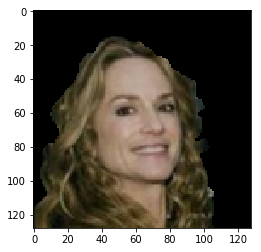

In [29]:
'''plot sample of face image'''

plt.imshow(x_read[25,:,:,:])
plt.show()

### 2) Designing the Neural Network

In case of parametrizing human face, human face can be considered as multivariate functions in two dimensions. While input of the multivariate function are the location information (x and y coordinates value), output of the multivariate function can be considered as pixel intensity values (RGB intensity values). With this intuition as in our instance segmentation approach for building detection in previous notebooks, CNN can be used to estimate parameters that represent a face, then those parameters can be re-arranged as weights and biases of vanilla neural network (MLP) generating face image from the estimated parameters. And whole network can be trained end to end manner with input and output images of same faces.

Hera we have used multi layers vanilla neural network (MLP) to parameterize faces with 2,307-element vectors.

In [30]:
img_dim = 128 # input dimension 
out_var = 3 # output bands (R, G and B intensity values)
hidden_size = 32 # hidden sizes of vanilla neural network of Vec2Instace
num_param = (2*hidden_size + hidden_size) + 2*(hidden_size*hidden_size + hidden_size) + (hidden_size*out_var + out_var) # total number of parameters in vanilla neural network of Vec2Instace 

'''Encoder Section'''

x_in = Input(shape=(None, None, 3)) # input shape: (height, width, 3 bands of RGB)
x_temp = Conv2D(32, (3, 3), activation='relu', padding='same')(x_in)
x_temp = Dropout(0.25)(x_temp)
x_temp = Conv2D(32, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = MaxPooling2D((2,2))(x_temp)
x_temp = Conv2D(32, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = Dropout(0.25)(x_temp)
x_temp = Conv2D(32, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = MaxPooling2D((2,2))(x_temp)
x_temp = Conv2D(64, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = Dropout(0.25)(x_temp)
x_temp = Conv2D(64, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = MaxPooling2D((2,2))(x_temp)
x_temp = Conv2D(64, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = Dropout(0.25)(x_temp)
x_temp = Conv2D(64, (3, 3), activation='relu', padding='same')(x_temp)

x_temp = Conv2D(64, (1, 1), activation='relu', padding='same')(x_temp)
x_temp = Conv2D(64, (1, 1), activation='relu', padding='same')(x_temp)
x_cnn = Conv2D(num_param, (1, 1), activation='linear', padding='same')(x_temp) # output bands are corresponding to number of parameters in vanilla neural network (MLP) of Vec2Instace.

'''Extracting the vector at the middle from the output of the encoder. This vector parametrize the shape of a face'''

def get_middle_param(arg_in):
    mid_idx = tf.shape(arg_in)[1]/2
    dec_para = arg_in[:, K.cast(mid_idx,"int32"), K.cast(mid_idx,"int32"), :]    
    return dec_para

'''rearranging the vector at the middle as vanilla neural network (MLP) of Vec2Instace'''

def decorder2D(arg_in):
    
    dec_size = tf.shape(arg_in)[0]
    
    # creating input of vanilla neural network (x and y coordinates)
    xx, yy = tf.meshgrid(tf.range(-img_dim/2, img_dim/2), tf.range(-img_dim/2, img_dim/2))
    xx = K.transpose(K.flatten(tf.to_float(xx)))
    yy = K.transpose(K.flatten(tf.to_float(yy)))
    xx_yy_stack = K.stack((xx, yy), axis=1)
    lyr_in = K.tile( K.reshape(xx_yy_stack, (1,img_dim*img_dim,2)), (dec_size,1,1))
    
    cur_loc = 0 # this stores current location of arg_in that has already taken
    
    # fist layer
    lyr_wgt = K.reshape( arg_in[:, cur_loc:cur_loc+hidden_size*2], (dec_size,2,hidden_size))
    cur_loc = cur_loc+hidden_size*2
    lyr_b = tf.matmul(tf.ones((dec_size,img_dim*img_dim,1)), K.reshape(arg_in[:,cur_loc:cur_loc+hidden_size], (dec_size,1,hidden_size)))
    cur_loc = cur_loc+hidden_size
    lyr_out = K.tanh( tf.matmul(lyr_in, lyr_wgt) +  lyr_b) 
    
    # hidden layer 1
    lyr_wgt = K.reshape( arg_in[:, cur_loc:cur_loc+hidden_size*hidden_size], (dec_size,hidden_size,hidden_size))
    cur_loc = cur_loc+hidden_size*hidden_size
    lyr_b = tf.matmul(tf.ones((dec_size,img_dim*img_dim,1)), K.reshape(arg_in[:, cur_loc:cur_loc+hidden_size], (dec_size,1,hidden_size)))
    cur_loc = cur_loc+hidden_size
    lyr_out = K.tanh( tf.matmul(lyr_out, lyr_wgt) +  lyr_b)
    
    # hidden layer 2
    lyr_wgt = K.reshape( arg_in[:, cur_loc:cur_loc+hidden_size*hidden_size], (dec_size,hidden_size,hidden_size))
    cur_loc = cur_loc+hidden_size*hidden_size
    lyr_b = tf.matmul(tf.ones((dec_size,img_dim*img_dim,1)), K.reshape(arg_in[:, cur_loc:cur_loc+hidden_size], (dec_size,1,hidden_size)))
    cur_loc = cur_loc+hidden_size
    lyr_out = K.tanh( tf.matmul(lyr_out, lyr_wgt) +  lyr_b)
    
    # final layer
    lyr_wgt = K.reshape( arg_in[:, cur_loc:cur_loc+hidden_size*out_var], (dec_size,hidden_size,out_var))
    cur_loc = cur_loc+hidden_size*out_var
    lyr_b = tf.matmul(tf.ones((dec_size,img_dim*img_dim,1)), K.reshape(arg_in[:, cur_loc:cur_loc+out_var], (dec_size,1,out_var)))
    cur_loc = cur_loc+out_var
    lyr_out = K.sigmoid( tf.matmul(lyr_out, lyr_wgt) + lyr_b ) 

    lyr_out_img = K.reshape( lyr_out, (dec_size,img_dim,img_dim,out_var))
    
    return lyr_out_img

x_param = Lambda(get_middle_param)(x_cnn)
x_out = Lambda(decorder2D)(x_param)

model = Model(inputs=x_in, outputs=x_out)

model.compile(loss=keras.losses.mean_squared_error, optimizer=keras.optimizers.Adam()) # setting loss and optimizer

model.summary() # printing the model summary

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, None, None, 32)    896       
_________________________________________________________________
dropout_21 (Dropout)         (None, None, None, 32)    0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, None, None, 32)    9248      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, None, None, 32)    0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, None, None, 32)    9248      
_________________________________________________________________
dropout_22 (Dropout)         (None, None, None, 32)    0         
__________

### 3) Training and Prediction

In [ ]:
'''training the model'''

batch_size = 100
epochs = 200

fit_h = model.fit(x_read, x_read, batch_size=batch_size, epochs=epochs, verbose=0, shuffle=1, validation_split=0.33)

*Note: set verbose=1 to see training progress for each epoch. Single epoch takes 4s in single NVIDIA GTX 1080 Ti GPU.*

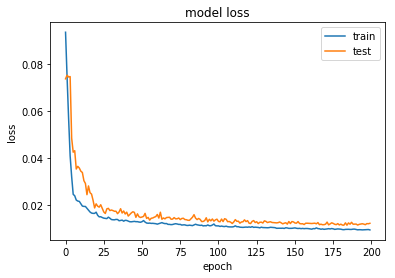

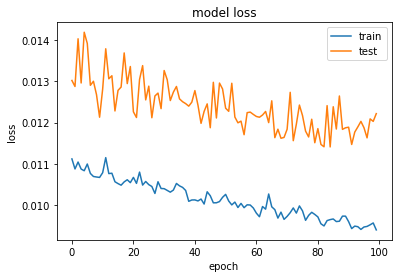

In [32]:
# plotting all 200 epochs
plt.plot(fit_h.history['loss'])
plt.plot(fit_h.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# plotting last 100 epochs
plt.plot(fit_h.history['loss'][100:])
plt.plot(fit_h.history['val_loss'][100:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [34]:
'''prediction outputs from the trained model '''

y_pred = model.predict(x_read, batch_size=batch_size)
print(y_pred.shape);

(2922, 128, 128, 3)


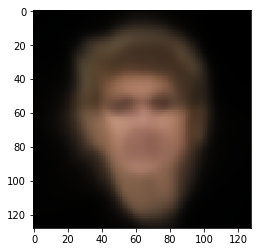

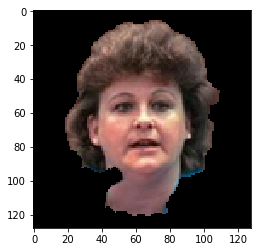

In [35]:
'''plot a sample prediction vs actual face'''

plt.imshow(y_pred[57,:,:,:], vmin=0, vmax=1)
plt.show()
plt.imshow(x_read[57,:,:,:], vmin=0, vmax=1)
plt.show()

### 4) t-SNE Visualization of Face Parameter Space

In [37]:
'''predicting parameter space'''

# defining a new model to extract parameter space (middle vector of the output of the encoder)
model_param = Model(inputs=x_in, outputs=x_param)

# predicting parameter space of faces
y_pred_param = model_param.predict(x_read, batch_size=batch_size)

print(y_pred_param.shape) # printing predicted output's shape

(2922, 2307)


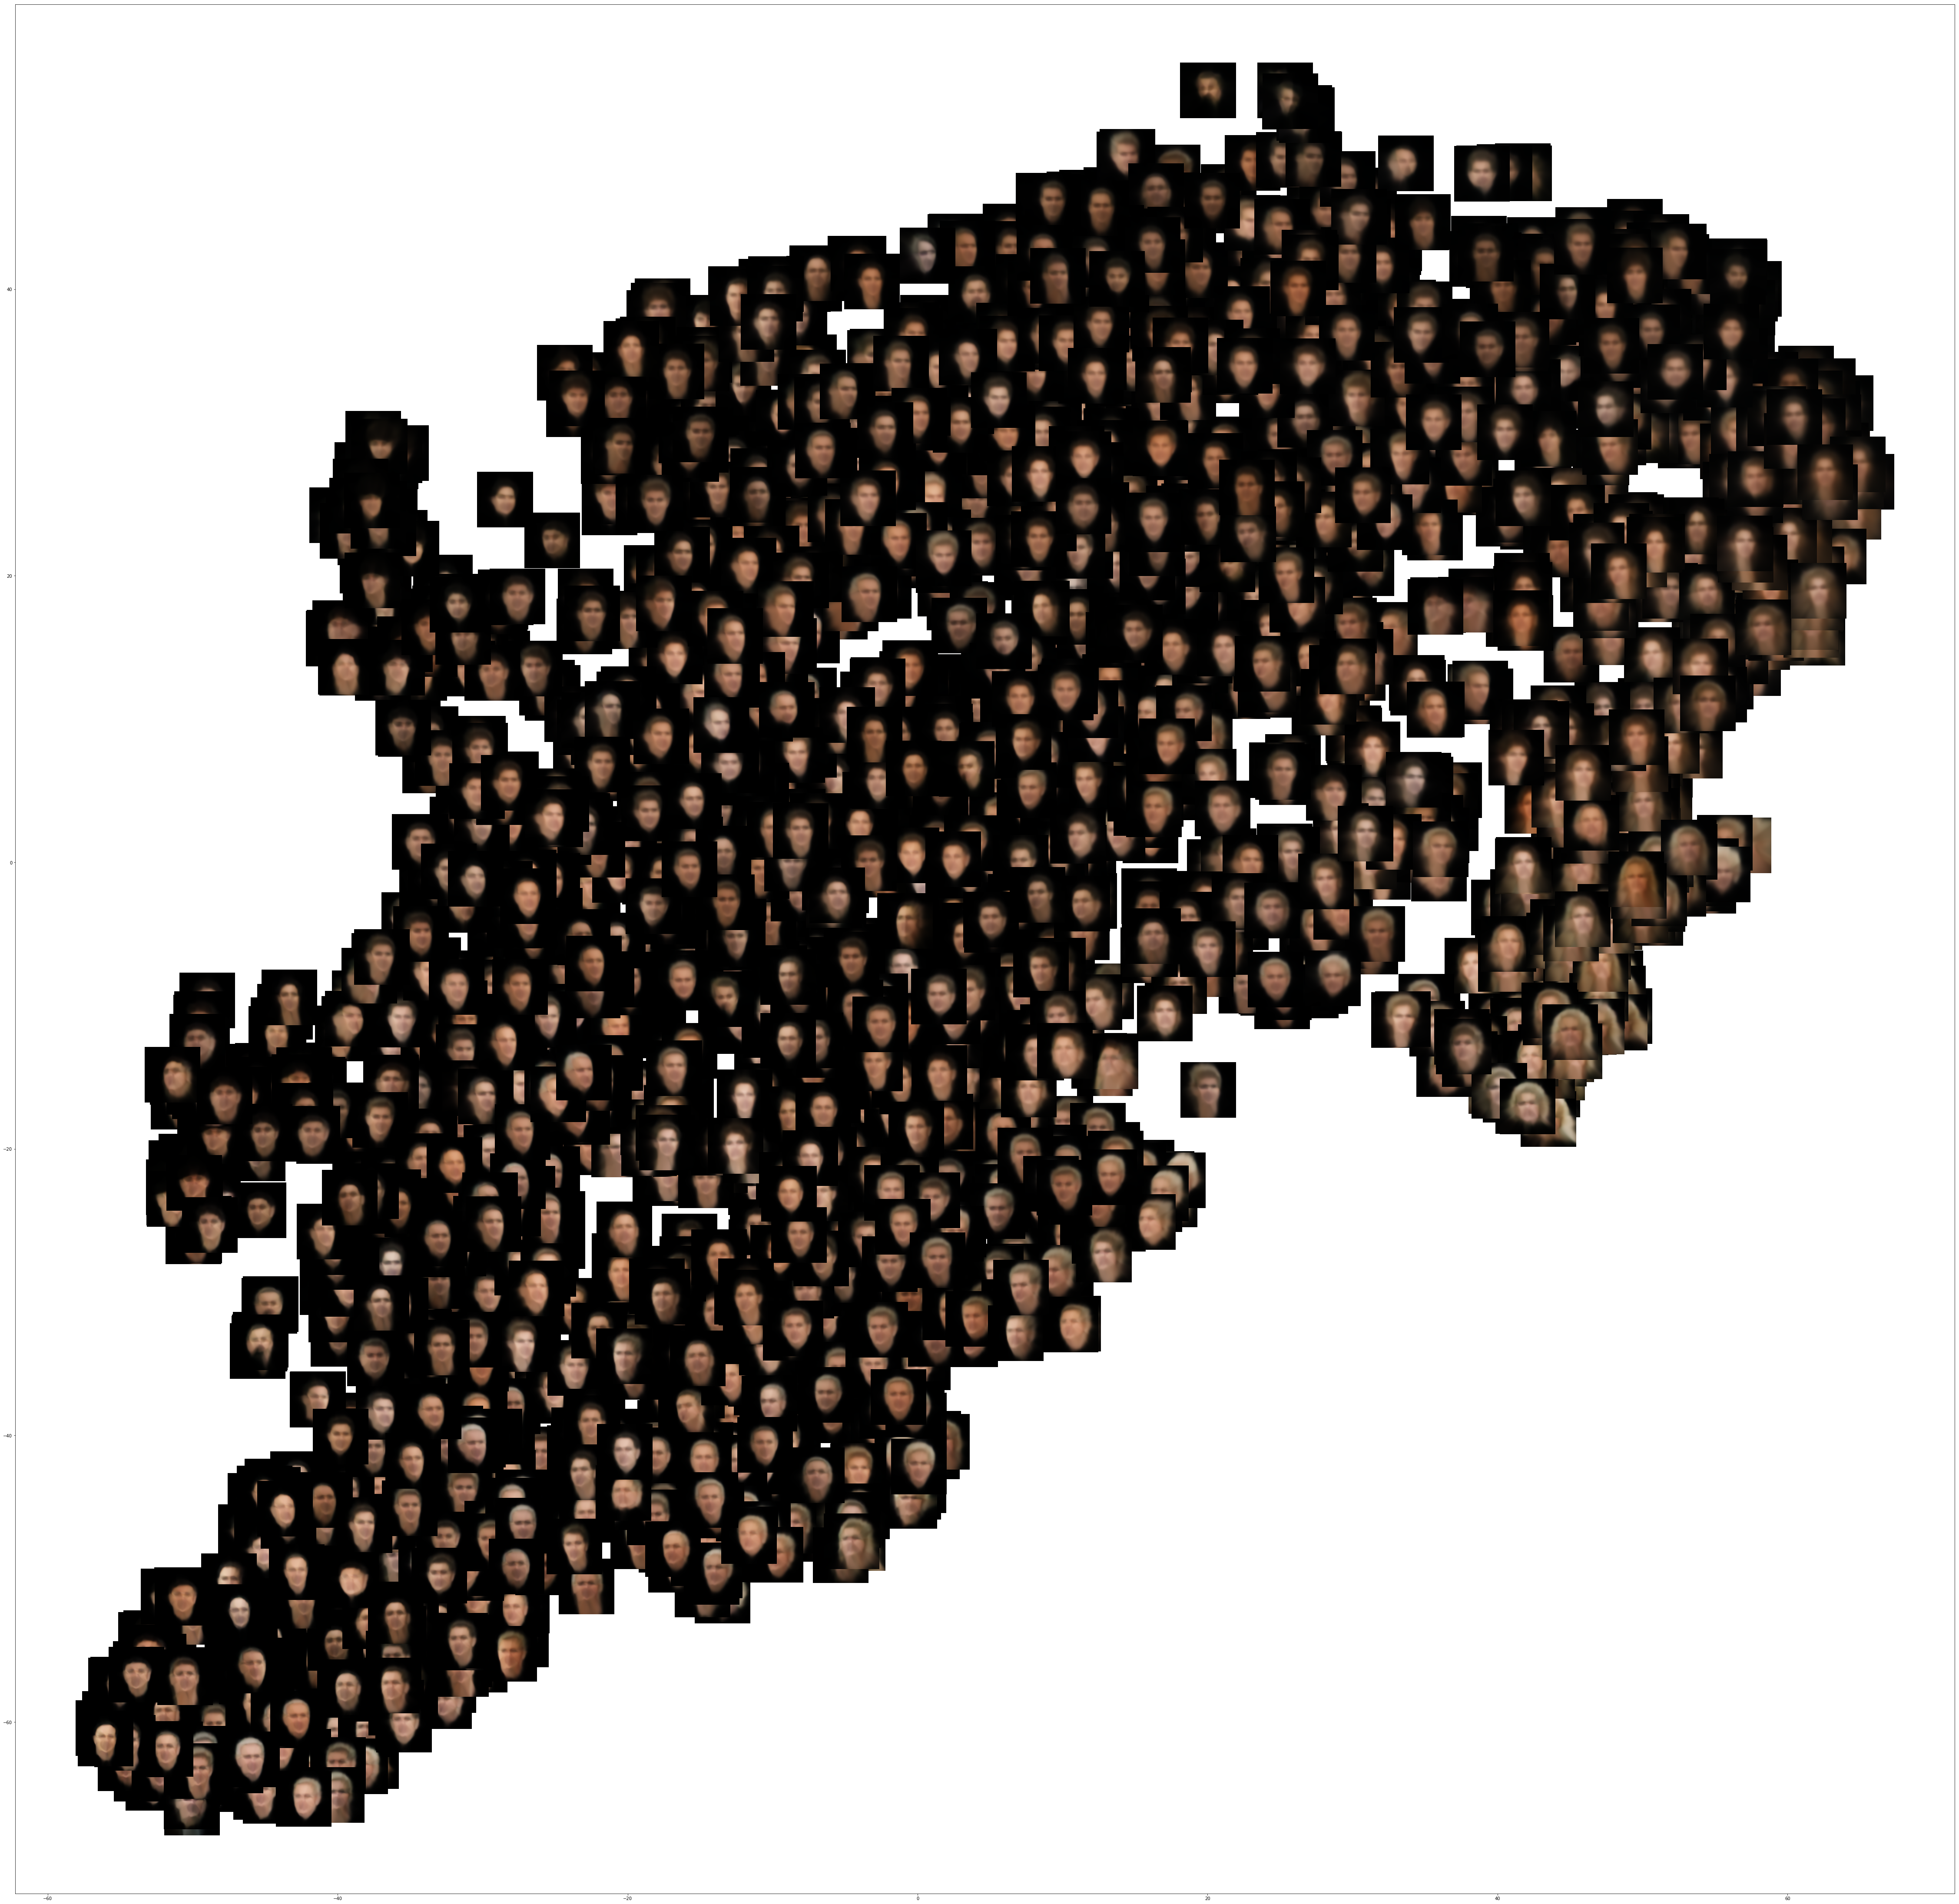

In [40]:
'''t-SNE dimensionality reduction and visualizing reconstructed faces in 2D'''

from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from sklearn.manifold import TSNE

# t-SNE dimensionality reduction from 2,307-element vectors space to 2-element vectors space
tsne = TSNE(n_components=2, random_state=0)
tsne_component = tsne.fit_transform(y_pred_param)

# plotting reconstructed faces with t-SNE 2-element components
fig, ax = plt.subplots(figsize=(80, 80))
ax.scatter(tsne_component[:,0], tsne_component[:,1]) 
for ii in range(2922):
    ab = AnnotationBbox(OffsetImage(y_pred[ii,:,:,:]), (tsne_component[ii,0], tsne_component[ii,1]), frameon=False)
    ax.add_artist(ab)

*__Note__: Reference to code in above cell: https://stackoverflow.com/questions/22566284/matplotlib-how-to-plot-images-instead-of-points/53851017*